# | 실습3 | MobileNetV2 변형해 보기

- **채점 기준**
  - 아래 과제 설명을 따라야한다.
  - test accuracy가 **80% 이상** 나와야 한다.
- **제출**
  - output 지우지 말아 주세요

---

`BatchNormalization(axis, momentum, epsilon)` : https://keras.io/api/layers/normalization_layers/batch_normalization/
- axis: Batch normalization이 적용될 axis. 우리는 채널에 대해서 BN을 적용할 것이다. 
- momentum: Moving average에 적용될 momentum 계수
- epsilon: 0으로 나누는 것을 방지하기 위한 작은 수.


`DepthwiseConv2D(kernel_size, strides, padding, use_bias, depthwise_regularizer)` : https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/

paper:[MobileNetV3](https://openaccess.thecvf.com/content_ICCV_2019/papers/Howard_Searching_for_MobileNetV3_ICCV_2019_paper.pdf)  

이번 실습에서는 MobileNetV3에서 추가된 내용 중 일부를 반영해 볼 것이다. MobilenetV3에서는 모델의 마지막 부분에 아래 그림과 같은 변화가 있었는데, 요약하자면
* Average pooling 앞의 1x1 Convolution layer와 Average pooling layer의 순서를 바꾸어 줌으로써 Computation은 줄이면서 정보의 손실은 최소화하였다.
* 위 변화가 일어나게 됨으로써 그 이전 Inverted residual layer에서 projection/filtering을 해 줄 필요가 없어졌다. 따라서 마지막 Inverted residual layer의 Expansion 이후 바로 Average pooling이 오게 된다.
* 아래 그림을 보면 더 이해가 쉬울 것이다.
<img src="https://user-images.githubusercontent.com/37704174/112775642-734f8a80-9078-11eb-9bc1-a860a1fea407.PNG" width="700" height="700"/> 
* 마지막 Inverted residual layer는 Original last stage 그림에서 맨 앞 세개이다.


<br>
위 내용을 참조하여 Network의 마지막 부분을 변형한 MobileNetV2plus를 구성하라. 위 그림상의 H-swish는 고려하지 않아도 된다.
<img src="https://user-images.githubusercontent.com/37704174/112777027-1229b600-907c-11eb-9f89-a7b61c0843be.PNG" width="700" height="700"/>  

- **채점기준**
  - 위의 변경 사항 반영하기
    - MobileNetV2에서 마지막 inverted residual block 및 뒷부분을 고치면 됨
    - Average pooling의 output의 가로 세로는 1임
  - test accuracy **80%** 이상
    - BatchNormalization, Activation, Dropout, Regularization, Weight initialization 등 자유롭게 수정, 추가, 제거 가능
    - `strides` 수정 가능
    - 나머지는 그대로


## Import Modules

In [1]:
import tensorflow as tf
### Q1. Import modules ###
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Activation, Flatten, Conv2D, \
    DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D, Dropout, AveragePooling2D
from tensorflow.keras.regularizers import l2
#########################

In [2]:
"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Inverted Residual Block

In [48]:
def _inverted_res_block(inputs, expansion, filters, strides):
    x = inputs
    in_chnls = inputs.shape[-1]
    # Expansion
    if expansion != 1:
        x = Conv2D(kernel_size=1, filters=in_chnls * expansion, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
        x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
        x = ReLU(max_value=6)(x)
        x = Dropout(0.2)(x)

    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False, depthwise_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)

    # Linear bottleneck
    x = Conv2D(kernel_size=1, filters=filters, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    # No activation
    
    # Residual connection
    if in_chnls == filters and strides == 1:
        x = Add()([inputs, x])
        
    return x #return output of layer

## MobileNetV2 변형 구현

In [49]:
def MobileNetV2plus(input_shape, classes):
    inputs = Input(shape=input_shape)
    
    ### Q2. Modify MobileNetV2 ###
    # 32x32x3 - conv3
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    x = Dropout(0.2)(x)

    # 16x16x32 - resblock
    x = _inverted_res_block(inputs=x, expansion=1, filters=16, strides=1)

    # 16x16x16 - resblock
    x = _inverted_res_block(inputs=x, expansion=6, filters=24, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=24, strides=1)
    
    # 8x8x24 - resblock
    x = _inverted_res_block(inputs=x, expansion=6, filters=32, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=32, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=32, strides=1)
    
    # 4x4x32 - resblock
    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=1)
    
    # 2x2x64 - resblock
    x = _inverted_res_block(inputs=x, expansion=6, filters=96, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=96, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=96, strides=1)

    # 2x2x96 - resblock
    x = _inverted_res_block(inputs=x, expansion=6, filters=160, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=160, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=160, strides=1)

    # last inverted_resblock(modified)
    x = Conv2D(kernel_size=1, filters=160 * 6, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    # avg pool
    x = AveragePooling2D(pool_size=x.shape[1])(x)

    # conv1
    x = Conv2D(filters=1280, kernel_size=1, strides=1)(x)
    x = ReLU(max_value=6)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)

    # output
    outputs = Dense(classes, activation='softmax')(x)
    ##############################
                                    
    return Model(inputs=inputs, outputs=outputs)


In [50]:
my_mobilenet = MobileNetV2plus(input_shape=(32,32,3),classes=10)

In [6]:
my_mobilenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 32)   0           ['batch_normalization[0][0]']

## Training Data

- keras dataset 혹은 tensorflow dataset 이용
- train data를 9:1로 나눠서 validation data로 이용

In [7]:
from tensorflow.keras.datasets import cifar10
#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.1)

170498071/170498071 [==============================] - 13s 0us/step


## Data Preprocessing
자유롭게 전처리

In [8]:
### Q3. Preporcessing ###
x_train = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x_train)
x_valid = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x_valid)
x_test = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x_test)
#########################

## Model Compile
loss function, optimizer 설정

In [51]:
### Q4. Model compile ###
my_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#########################

In [43]:
### Q5. Callbacks ###
callbacks = []

def decay(epoch):
    ####### 실습 #######
    if epoch < 5:
        return 0.0005
    else:
        return 0.001

#callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))
#callbacks.append(tf.keras.callbacks.LearningRateScheduler(decay))
#####################

## Model Training
hyperparameter를 적절히 설정한다. (epochs 등..)

In [52]:
### Q6. Training ###
history = my_mobilenet.fit(x_train, y_train, batch_size=64, 
                          epochs= 100,
                          callbacks=callbacks,              
                          validation_data=(x_valid, y_valid))
####################

Epoch 1/100
704/704 [==============================] - 23s 24ms/step - loss: 2.2245 - accuracy: 0.2162 - val_loss: 2.4789 - val_accuracy: 0.0974
Epoch 2/100
704/704 [==============================] - 15s 21ms/step - loss: 1.8422 - accuracy: 0.3600 - val_loss: 2.5038 - val_accuracy: 0.0974
Epoch 3/100
704/704 [==============================] - 16s 22ms/step - loss: 1.7023 - accuracy: 0.4185 - val_loss: 2.4670 - val_accuracy: 0.0974
Epoch 4/100
704/704 [==============================] - 15s 21ms/step - loss: 1.5914 - accuracy: 0.4685 - val_loss: 2.4733 - val_accuracy: 0.0996
Epoch 5/100
704/704 [==============================] - 15s 22ms/step - loss: 1.4967 - accuracy: 0.5058 - val_loss: 2.4374 - val_accuracy: 0.1004
Epoch 6/100
704/704 [==============================] - 15s 22ms/step - loss: 1.4191 - accuracy: 0.5359 - val_loss: 2.2692 - val_accuracy: 0.1862
Epoch 7/100
704/704 [==============================] - 15s 22ms/step - loss: 1.3557 - accuracy: 0.5619 - val_loss: 1.8492 - val_ac

## 참고용
조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

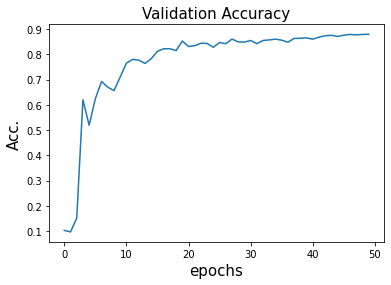

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

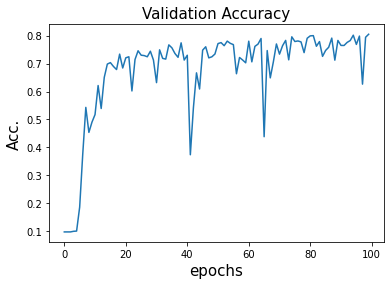

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

test accuracy 측정 결과 **80% 이상**이 나와야 한다.

In [54]:
my_mobilenet.evaluate(x_test,y_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.7732 - accuracy: 0.7916


[0.7732448577880859, 0.7915999889373779]